In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

from catboost import CatBoostClassifier
from sklearn import tree
from sklearn.tree import _tree


import xgboost as xgb

SEED = 42

# Filename to save/load models

In [36]:
filename = '../models/test 65%/'

# Functions defining

In [37]:
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " then "
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules

In [38]:
def print_scores(y_true, y_pred):
    print('ROCAUC score:',roc_auc_score(y_true, y_pred).round(4))
    print('Accuracy score:',accuracy_score(y_true, y_pred).round(4))
    print('F1 score:',f1_score(y_true, y_pred).round(4))
    print('Precision score:',precision_score(y_true, y_pred).round(4))
    print('Recall:',recall_score(y_true, y_pred).round(4))

def run_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    return score, y_pred

def tune_model(model, param_grid, n_iter, X_train, y_train):
    grid = RandomizedSearchCV(model, param_grid, verbose=20,
        scoring='roc_auc', cv=3, n_iter=n_iter)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    return best_model

# Load data

In [39]:
df = pd.read_csv('../data/Parameters_90%stability.csv')
df = df.drop(['Unnamed: 0'], axis = 1)
df.head(3)

,Gamma_AATA,Gamma_IPPS,Gamma_IPPSm,Gamma_DHQTi,Gamma_ADCS,Gamma_ABTA,Gamma_PGL,Gamma_ACACT1r,Gamma_ACOAHim,Gamma_ACOTAim,...,sigma_km_product_ccm2tp,sigma_km_substrate_pca2tp,sigma_km_product_pca2tp,sigma_km_substrate_r2073_1,sigma_km_product_r2073_1,sigma_km_substrate1_r_4235,sigma_km_product1_r_4235,sigma_km_substrate2_r_4235,sigma_km_product2_r_4235,Stability
0,0.072899,0.005997,7.820000e-15,0.006337,4.840000e-08,0.976899,0.081794,0.906322,5.030000e-12,0.198783,...,0.333927,0.112272,0.241996,0.580106,0.658892,0.950488,0.214360,0.271523,0.527818,1
1,0.072899,0.005997,7.820000e-15,0.006337,4.840000e-08,0.976899,0.081794,0.906322,5.030000e-12,0.198783,...,0.693616,0.302981,0.761936,0.059439,0.938477,0.722462,0.442469,0.426947,0.517426,0
2,0.071643,0.006483,3.750000e-15,0.006192,4.870000e-08,0.976932,0.089406,0.906766,3.250000e-12,0.200557,...,0.333927,0.112272,0.241996,0.580106,0.658892,0.950488,0.214360,0.271523,0.527818,0


In [40]:
df.shape

(372, 1411)

# Look at target variable

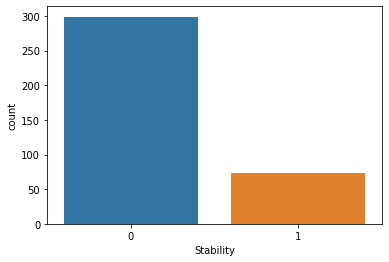

In [41]:
sns.countplot(data=df, x='Stability')
plt.show()

In [42]:
SI = len(df[df['Stability']==1])/len(df) * 100
print("The Stability Index is: SI =",round(SI, 4), "%")

The Stability Index is: SI = 19.6237 %


Imbalanced dataset

# Split train - test

In [43]:
from sklearn.model_selection import train_test_split

# Load X and Y 
X = df.drop(['Stability'], axis = 1)
y = df['Stability']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.35,
                                                stratify=y, random_state=SEED)

y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

In [44]:
print('train',x_train.shape)
print('test',x_test.shape)

train (241, 1410)
test (131, 1410)


In [45]:
SI_train = len(y_train[y_train['Stability']==1])/len(y_train) * 100
print("The Stability Index on TRAIN SET is: SI =",round(SI_train, 4), "%")

SI_test = len(y_test[y_test['Stability']==1])/len(y_test) * 100
print("The Stability Index on TEST SET is: SI =",round(SI_test, 4), "%")

The Stability Index on TRAIN SET is: SI = 19.5021 %
The Stability Index on TEST SET is: SI = 19.8473 %


# _Feature_names_ and _class_names_

In [46]:
class_names = y_train['Stability'].unique().astype(str)
feature_names = x_train.columns.values

# Normalize data

In [48]:
scaler = StandardScaler()

X_train = scaler.fit_transform(x_train)
X_test = scaler.transform(x_test)

X_train = pd.DataFrame(X_train, columns=x_train.columns)
X_train.index = x_train.index

X_test = pd.DataFrame(X_test, columns=x_test.columns)
X_test.index = x_test.index

# BLACK-BOX MODEL

## SVM

In [21]:
try:
    
    # load the model from disk
    best_svc = pickle.load(open(filename+'/svc_model.sav', 'rb'))

except FileNotFoundError:

    # =================
    # SVC
    # =================

    param_grid_svc = {'C': [0.001, 0.005, 0.01, 0.02, 0.05, 0.08, 1, 1.5, 2, 2.5, 3, 5, 10, 12, 20, 25, 50],
                'gamma': [0.002, 0.003, 0.004, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5],
                'kernel': ['rbf', 'linear']
    }

    svc = SVC(random_state=SEED)
    best_svc = tune_model(svc, param_grid_svc, 1000, X_train, y_train.values.ravel())
    score, y_pred_svc = run_model(best_svc, X_train, y_train.values.ravel(),
        X_test, y_test.values.ravel())

    pickle.dump(best_svc, open(filename+'/svc_model.sav', 'wb'))   


In [22]:
print(best_svc)

SVC(C=0.02, gamma=0.002, kernel='linear', random_state=42)


In [24]:
y_pred_svc = best_svc.predict(X_test)
print_scores(y_test, y_pred_svc)

ROCAUC score: 0.7262
Accuracy score: 0.8626
F1 score: 0.5909
Precision score: 0.7222
Recall: 0.5


## CatBoost

In [15]:
try:
    
    # load the model from disk
    catboost = pickle.load(open(filename+'/cat_model.sav', 'rb'))

except FileNotFoundError:

    # =================
    # CatBoost
    # =================
    catboost = CatBoostClassifier(random_state=SEED)
    catboost.fit(X_train, y_train.values.ravel())
    score, y_pred_cat = run_model(catboost, X_train, y_train.values.ravel(),
        X_test, y_test.values.ravel())

    pickle.dump(catboost, open(filename+'/cat_model.sav', 'wb'))   

Learning rate set to 0.005611
0:	learn: 0.6882694	total: 217ms	remaining: 3m 37s
1:	learn: 0.6832533	total: 267ms	remaining: 2m 13s
2:	learn: 0.6778084	total: 317ms	remaining: 1m 45s
3:	learn: 0.6725863	total: 373ms	remaining: 1m 32s
4:	learn: 0.6669994	total: 438ms	remaining: 1m 27s
5:	learn: 0.6620877	total: 497ms	remaining: 1m 22s
6:	learn: 0.6570991	total: 546ms	remaining: 1m 17s
7:	learn: 0.6530484	total: 594ms	remaining: 1m 13s
8:	learn: 0.6482184	total: 647ms	remaining: 1m 11s
9:	learn: 0.6426886	total: 704ms	remaining: 1m 9s
10:	learn: 0.6383360	total: 753ms	remaining: 1m 7s
11:	learn: 0.6337233	total: 802ms	remaining: 1m 6s
12:	learn: 0.6295388	total: 853ms	remaining: 1m 4s
13:	learn: 0.6252506	total: 909ms	remaining: 1m 4s
14:	learn: 0.6205792	total: 959ms	remaining: 1m 2s
15:	learn: 0.6157710	total: 1.01s	remaining: 1m 1s
16:	learn: 0.6119672	total: 1.06s	remaining: 1m 1s
17:	learn: 0.6075580	total: 1.11s	remaining: 1m
18:	learn: 0.6031441	total: 1.16s	remaining: 1m
19:	lear

In [20]:
y_pred_cat = catboost.predict(X_test)
print_scores(y_test, y_pred_cat)

ROCAUC score: 0.6925
Accuracy score: 0.855
F1 score: 0.5366
Precision score: 0.7333
Recall: 0.4231


# SURROGATE MODEL

Εκπαίδευση του surrogate model (decision tree) στο train set χρησιμοποιώντας τις προβλέψεις του svm στο train set.

`print_scores` on training set

In [21]:
y_pred_train_svc = best_svc.predict(X_train)
print_scores(y_train, y_pred_train_svc)

ROCAUC score: 0.9391
Accuracy score: 0.9668
F1 score: 0.913
Precision score: 0.9333
Recall: 0.8936


In [22]:
# =================
# DecisionTree
# =================
surrogate = DecisionTreeClassifier(random_state=SEED)

score, y_pred_surrogate = run_model(surrogate, X_train, y_pred_train_svc,
    X_test, y_test.values.ravel())

In [24]:
print_scores(y_test, y_pred_surrogate)

ROCAUC score: 0.6832
Accuracy score: 0.8168
F1 score: 0.5
Precision score: 0.5455
Recall: 0.4615


## Extract rules

In [25]:
rules = get_rules(surrogate, feature_names=feature_names, 
                  class_names=class_names)

rules

['if (Gamma_GLUDC > -1.277) and (sigma_km_product2_GLUDy <= 1.472) and (sigma_km_product2_GF6PTA > -1.526) and (sigma_km_product1_PYNP2r <= 1.521) and (sigma_km_substrate2_PHETRA <= 1.732) then class: 0 (proba: 100.0%) | based on 156 samples',
 'if (Gamma_GLUDC <= -1.277) and (sigma_km_substrate1_2OXOADPTm <= 0.494) and (sigma_km_substrate26_LMPD_s_0450_c_1_256 <= 0.398) and (sigma_km_substrate2_GK1 <= 1.581) then class: 1 (proba: 100.0%) | based on 31 samples',
 'if (Gamma_GLUDC <= -1.277) and (sigma_km_substrate1_2OXOADPTm > 0.494) then class: 0 (proba: 100.0%) | based on 20 samples',
 'if (Gamma_GLUDC <= -1.277) and (sigma_km_substrate1_2OXOADPTm <= 0.494) and (sigma_km_substrate26_LMPD_s_0450_c_1_256 > 0.398) then class: 0 (proba: 100.0%) | based on 6 samples',
 'if (Gamma_GLUDC > -1.277) and (sigma_km_product2_GLUDy > 1.472) and (sigma_km_substrate1_MALtm > 0.077) then class: 0 (proba: 100.0%) | based on 5 samples',
 'if (Gamma_GLUDC > -1.277) and (sigma_km_product2_GLUDy > 1.472)

# Validation set

## Rule 1:

-    'if (Gamma_GLUDC <= -1.277) and (sigma_km_substrate1_2OXOADPTm <= 0.494) and (sigma_km_substrate26_LMPD_s_0450_c_1_256 <= 0.398) and (sigma_km_substrate2_GK1 <= 1.581) then class: 1 (proba: 100.0%) | based on 31 samples',

Sample from test set rows based on __Rule 1__ (_Validation set_)

In [28]:
index_GP = X_test[(X_test['Gamma_GLUDC'] <= -1.277) 
            & (X_test['sigma_km_substrate1_2OXOADPTm'] <= 0.494) 
            & (X_test['sigma_km_substrate26_LMPD_s_0450_c_1_256'] <= 0.398)
            & (X_test['sigma_km_substrate2_GK1'] <= 1.581)].index

len(index_GP)

18

In [29]:
y_val = y_test.loc[index_GP]
SI_val = y_val['Stability'].value_counts()[1] / len(y_val)
print("The Stability Index on VALIDATION SET (sampled from TEST SET) is: SI =",round(SI_val, 4), "%")

print("The Stability Index on TEST SET is: SI =",round(SI_test, 4), "%")

The Stability Index on VALIDATION SET (sampled from TEST SET) is: SI = 0.6111 %
The Stability Index on TEST SET is: SI = 19.8473 %


# Extract Rules using DecisionTree 

In [31]:
try:
    
    # load the model from disk
    best_tree = pickle.load(open(filename+'/tuned_tree_model', 'rb'))

except FileNotFoundError:

    # ===============
    # DecisionTree
    # =================

    param_grid_tree = {
        'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 25, 30, 40, 50, 100],
        'min_samples_leaf': [5, 6, 7, 8, 9, 10, 15, 20, 25, 50, 100],
        'criterion': ["gini", "entropy"]
    }

    dec_tree = DecisionTreeClassifier(random_state=SEED)

    best_tree = tune_model(dec_tree, param_grid_tree, 1000, X_train, y_train.values.ravel())
    score, y_pred = run_model(best_tree, X_train, y_train.values.ravel(),
        X_test, y_test.values.ravel())

    pickle.dump(best_tree, open(filename+'/tuned_tree_model', 'wb'))   

/home/comex/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 330 is smaller than n_iter=1000. Running 330 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 330 candidates, totalling 990 fits
[CV 1/3; 1/330] START criterion=gini, max_depth=2, min_samples_leaf=5...........
[CV 1/3; 1/330] END criterion=gini, max_depth=2, min_samples_leaf=5;, score=0.696 total time=   0.1s
[CV 2/3; 1/330] START criterion=gini, max_depth=2, min_samples_leaf=5...........
[CV 2/3; 1/330] END criterion=gini, max_depth=2, min_samples_leaf=5;, score=0.626 total time=   0.0s
[CV 3/3; 1/330] START criterion=gini, max_depth=2, min_samples_leaf=5...........
[CV 3/3; 1/330] END criterion=gini, max_depth=2, min_samples_leaf=5;, score=0.694 total time=   0.0s
[CV 1/3; 2/330] START criterion=gini, max_depth=2, min_samples_leaf=6...........
[CV 1/3; 2/330] END criterion=gini, max_depth=2, min_samples_leaf=6;, score=0.696 total time=   0.0s
[CV 2/3; 2/330] START criterion=gini, max_depth=2, min_samples_leaf=6...........
[CV 2/3; 2/330] END criterion=gini, max_depth=2, min_samples_leaf=6;, score=0.606 total time=   0.1s
[CV 3/3; 2/330] START crite

In [32]:
print(best_tree)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, random_state=42)


In [33]:
print_scores(y_test, y_pred)

ROCAUC score: 0.6782
Accuracy score: 0.8321
F1 score: 0.5
Precision score: 0.6111
Recall: 0.4231


In [34]:
rules = get_rules(best_tree, feature_names=feature_names, 
                  class_names=class_names)

rules

['if (Gamma_GLUDC > -1.277) and (sigma_km_product2_GLUDy <= 1.472) and (sigma_km_product2_GF6PTA > -1.452) and (sigma_km_product2_SUCOAACTm <= 1.395) then class: 0 (proba: 100.0%) | based on 140 samples',
 'if (Gamma_GLUDC <= -1.277) and (sigma_km_product1_ICDHxm > 0.056) and (sigma_km_product27_LMPD_s_0450_c_1_256 <= 0.76) then class: 1 (proba: 100.0%) | based on 18 samples',
 'if (Gamma_GLUDC > -1.277) and (sigma_km_product2_GLUDy > 1.472) then class: 0 (proba: 56.25%) | based on 16 samples',
 'if (Gamma_GLUDC > -1.277) and (sigma_km_product2_GLUDy <= 1.472) and (sigma_km_product2_GF6PTA > -1.452) and (sigma_km_product2_SUCOAACTm > 1.395) then class: 0 (proba: 81.25%) | based on 16 samples',
 'if (Gamma_GLUDC <= -1.277) and (sigma_km_product1_ICDHxm <= 0.056) and (sigma_km_product2_AKGMAL <= -0.354) then class: 0 (proba: 100.0%) | based on 14 samples',
 'if (Gamma_GLUDC <= -1.277) and (sigma_km_product1_ICDHxm > 0.056) and (sigma_km_product27_LMPD_s_0450_c_1_256 > 0.76) then class: 1

# Validation set

## Rule 1:

-  if (Gamma_GLUDC <= -1.277) and (sigma_km_product1_ICDHxm > 0.056) and (sigma_km_product27_LMPD_s_0450_c_1_256 <= 0.76) then class: 1 (proba: 100.0%) | based on 18 samples'


Sample from test set rows based on __Rule 1__ (_Validation set_)

In [35]:
index_GP = X_test[(X_test['Gamma_GLUDC'] <= -1.277) 
                  & (X_test['sigma_km_product1_ICDHxm'] > 0.056)
                  & (X_test['sigma_km_product27_LMPD_s_0450_c_1_256'] <= 0.76)].index

len(index_GP)

8

In [36]:
y_val = y_test.loc[index_GP]
SI_val = y_val['Stability'].value_counts()[1] / len(y_val)
print("The Stability Index on VALIDATION SET (sampled from TEST SET) is: SI =",round(SI_val, 4), "%")

print("The Stability Index on TEST SET is: SI =",round(SI_test, 4), "%")

The Stability Index on VALIDATION SET (sampled from TEST SET) is: SI = 0.625 %
The Stability Index on TEST SET is: SI = 19.8473 %


# SCOPE-RULES

In [37]:
# Import skope-rules
import six
import sys

sys.modules['sklearn.externals.six'] = six
from skrules import SkopeRules

In [38]:
# Train a skope-rules-boosting classifier
skope_rules_clf = SkopeRules(feature_names=feature_names, 
                             random_state=SEED,
                             # max_features='auto',
                             n_estimators=30,
                             recall_min=0.05, precision_min=0.9,
                             max_samples=0.7,
                             max_depth_duplication= 4, 
                             max_depth = 5, 
                             verbose=2)

skope_rules_clf.fit(X_train.values, y_train.values.reshape(-1,))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Building estimator 1 of 30 for this parallel run (total 30)...
Building estimator 2 of 30 for this parallel run (total 30)...
Building estimator 3 of 30 for this parallel run (total 30)...
Building estimator 4 of 30 for this parallel run (total 30)...
Building estimator 5 of 30 for this parallel run (total 30)...
Building estimator 6 of 30 for this parallel run (total 30)...
Building estimator 7 of 30 for this parallel run (total 30)...
Building estimator 8 of 30 for this parallel run (total 30)...
Building estimator 9 of 30 for this parallel run (total 30)...
Building estimator 10 of 30 for this parallel run (total 30)...
Building estimator 11 of 30 for this parallel run (total 30)...
Building estimator 12 of 30 for this parallel run (total 30)...
Building estimator 13 of 30 for this parallel run (total 30)...
Building estimator 14 of 30 for this parallel run (total 30)...
Building estimator 15 of 30 for this parallel run (total 30)...
Building estimator 16 of 30 for this parallel run

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Building estimator 3 of 30 for this parallel run (total 30)...
Building estimator 4 of 30 for this parallel run (total 30)...
Building estimator 5 of 30 for this parallel run (total 30)...
Building estimator 6 of 30 for this parallel run (total 30)...
Building estimator 7 of 30 for this parallel run (total 30)...
Building estimator 8 of 30 for this parallel run (total 30)...
Building estimator 9 of 30 for this parallel run (total 30)...
Building estimator 10 of 30 for this parallel run (total 30)...
Building estimator 11 of 30 for this parallel run (total 30)...
Building estimator 12 of 30 for this parallel run (total 30)...
Building estimator 13 of 30 for this parallel run (total 30)...
Building estimator 14 of 30 for this parallel run (total 30)...
Building estimator 15 of 30 for this parallel run (total 30)...
Building estimator 16 of 30 for this parallel run (total 30)...
Building estimator 17 of 30 for this parallel run (total 30)...
Building estimator 18 of 30 for this parallel r

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished


SkopeRules(feature_names=array(['Gamma_AATA', 'Gamma_IPPS', 'Gamma_IPPSm', ...,
       'sigma_km_product1_r_4235', 'sigma_km_substrate2_r_4235',
       'sigma_km_product2_r_4235'], dtype=object),
           max_depth=5, max_depth_duplication=4, max_samples=0.7,
           n_estimators=30, precision_min=0.9, random_state=42, recall_min=0.05,
           verbose=2)

In [39]:
print(str(len(skope_rules_clf.rules_)) + ' rules have been built with ' +
      'SkopeRules.\n')

for i_rule, rule in enumerate(skope_rules_clf.rules_[:4]):
    print(rule[0])  

29 rules have been built with SkopeRules.

Gamma_FBA <= -0.9118080735206604 and sigma_km_product1_ALCD26xi > -0.26216644048690796 and sigma_km_substrate1_ASPTA <= 1.1930022835731506
sigma_km_substrate2_VALTAim <= 1.3757104873657227 and Gamma_2PHETOHtm <= -1.313053548336029 and sigma_km_substrate1_ADK1 <= 1.5514056086540222 and sigma_km_product1_ICDHxm > -0.03848084434866905 and sigma_km_substrate2_ILETAm <= 1.3645450472831726
sigma_km_substrate1_ADK1 <= 1.5514056086540222 and Gamma_ORNTA <= -1.0557992458343506 and sigma_km_product1_ICDHxm > 0.05641191266477108 and sigma_km_substrate26_LMPD_s_0450_c_1_256 <= 0.3245595768094063
sigma_km_substrate1_ADK1 <= 1.5514056086540222 and Gamma_GLUDC <= -1.3166851997375488 and sigma_km_product_HCO3E > -1.57037752866745 and sigma_km_product1_ICDHxm > 0.33645980060100555


# Validation set

## Rule 1:

-  iGamma_FBA <= -0.9118080735206604 and sigma_km_product1_ALCD26xi > -0.26216644048690796 and sigma_km_substrate1_ASPTA <= 1.1930022835731506



Sample from test set rows based on __Rule 1__ (_Validation set_)

In [43]:
index_GP = X_test[(X_test['Gamma_FBA'] <= -0.9118080735206604) 
                & (X_test['sigma_km_product1_ALCD26xi'] > -0.26216644048690796)
                & (X_test['sigma_km_substrate1_ASPTA'] <= 1.1930022835731506)].index

len(index_GP)

11

In [45]:
y_val = y_test.loc[index_GP]
SI_val = y_val['Stability'].value_counts()[1] / len(y_val)
print("The Stability Index on VALIDATION SET (sampled from TEST SET) is: SI =",round(SI_val, 4), "%")

print("The Stability Index on TEST SET is: SI =",round(SI_test, 4), "%")

The Stability Index on VALIDATION SET (sampled from TEST SET) is: SI = 0.9091 %
The Stability Index on TEST SET is: SI = 19.8473 %
